# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [48]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from joblib import dump, load
from typing import Union, Tuple, List, Dict
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import set_config

# Enabling metadata in Pipeline
set_config(enable_metadata_routing=True)

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = 20
pd.options.display.max_columns = 10

# Project constants
PROCESSED_DATA_PATH = './data/'
CLUSTER_MODEL_PATH = './model/'

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [49]:
def load_data_from_pickle_file(filename: str, file_path: str = PROCESSED_DATA_PATH) -> pd.DataFrame:
    '''
    INPUT:
    filename - (string) the file name of the pickle file
    file_path - (string) the path name where the pickle file is held
    
    OUTPUT:
    data - (pandas dataframe) the dataframe object to load into a pickle file
    '''
    
    full_path = file_path + filename
    
    try:
        df_processed_data = load(full_path)
    except:
        print('Unable to load pickle file {}'.format(full_path))
        return pd.DataFrame()
    else:
        print('Loaded pickle file {}'.format(full_path))
        return df_processed_data

In [50]:
# Load the processed data of the general population from a pickle file
df_cleaned = load_data_from_pickle_file(filename='processed_data.pk', file_path=PROCESSED_DATA_PATH)

Loaded pickle file ./data/processed_data.pk


In [51]:
df_cleaned.head()

,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,...,FINANZTYP_Other,ZABEOTYP_1,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_Other
1,0.0,11.0,0.0,2.0,0.0,...,False,False,False,False,True
2,17.0,10.0,0.0,1.0,0.0,...,False,False,False,False,True
3,13.0,1.0,0.0,0.0,0.0,...,False,False,True,False,False
4,20.0,3.0,0.0,4.0,0.0,...,False,False,False,True,False
5,10.0,5.0,0.0,1.0,0.0,...,False,False,False,True,False


## Step 1: Feature Transformation

### Step 1.1: Building the Pipeline

In [52]:
# Apply feature scaling to the general population demographics data.
class Normalizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        """
        Setting up a robust scaler object for later use
        """
        self.rs = RobustScaler()
        self.df_normalized = None
        
    def fit(self, X: pd.DataFrame, y=None) -> RobustScaler:
        """
        Fitting the robust scaler object with the input dataframe X
        """
        self.columns = X.columns
        self.rs.fit(X)
        return self
        
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Normalizing the input dataframe X with the fitted robust scaler object
        """
        self.df_normalized = pd.DataFrame(self.rs.transform(X), columns=X.columns, index=X.index)
        return self.df_normalized
    
    def inverse_transform(self, X: np.array, labels: np.array, id_cluster: int) -> pd.DataFrame:
        """
        Denormalizing the numpy array X with the fitted robust scaler object
        """
        extracted_data = self.rs.inverse_transform(X)[np.where(labels==id_cluster)]      
        return pd.DataFrame(data=np.round(extracted_data), columns=self.columns)

In [53]:
class Reducer(BaseEstimator, TransformerMixin):
    def __init__(self):
        """
        Setting up a PCA object for later use
        """
        self.pca = PCA(random_state=42)
        self.Xpca = None
      
    def fit(self, X: pd.DataFrame, y=None) -> PCA:
        """
        Fitting the PCA object with the normalized dataframe X
        """
        self.pca.fit(X)
        return self
        
    def transform(self, X: pd.DataFrame) -> np.array:
        """
        Applying PCA to the normalized dataframe X
        """
        self.X_pca = self.pca.transform(X)
        return self.X_pca
    
    def inverse_transform(self, labels: np.array, id_cluster: int) -> Tuple[np.array, np.array, int]:
        """
        Going back to the original space
        """
        X_orig = np.dot(self.X_pca, self.pca.components_)
        
        return X_orig, labels, id_cluster

In [54]:
class Cluster(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.kmeans = KMeans(random_state=42)
    
    def fit(self, X: np.array, y=None) -> KMeans:
        """
        Fitting the kmeans with the reduced array X
        """
        self.kmeans.fit(X)
        return self
        
    def transform(self, X: np.array) -> np.array:
        """
        Do nothing, just return the input array
        """
        return X
    
    def inverse_transform(self, labels: np.array, id_cluster: int) -> Tuple[np.array, int]:
        """
        Do nothing, just return the inputs as outputs
        """      
        return labels, id_cluster
    
    def predict(self, X: np.array) -> np.array:
        return self.kmeans.predict(X)

In [55]:
# Building the full pipeline for using later in the customers dataset
full_pl = Pipeline([("normalizer", Normalizer()), 
                    ("reducer", Reducer()), 
                    ("cluster", Cluster())])

In [56]:
# Fit and transform the Robust Scaler and PCA
full_pl[0:2].fit(df_cleaned)

Pipeline(steps=[('normalizer', Normalizer()), ('reducer', Reducer())])

In [57]:
# Checking that the values of all columns are within 0 and 1
df_norm = full_pl['normalizer'].df_normalized
for col in df_norm.columns:
    assert df_norm[col].between(0, 1, inclusive='both').any(), "Some values are not within 0, 1 range in column {}".format(col)
print("All values are within the 0, 1 range")

# Ensuring that the amount of reduced features corresponds to the desired amount
assert len(full_pl['reducer'].pca.explained_variance_ratio_) == df_cleaned.shape[1], "Number of features mismatch: {} != {}".format(
       len(full_pl['reducer'].pca.explained_variance_ratio_), df_cleaned.shape[1])
print("Number of features match")

All values are within the 0, 1 range
Number of features match


### Step 1.2: Improve Dimensionality Reduction

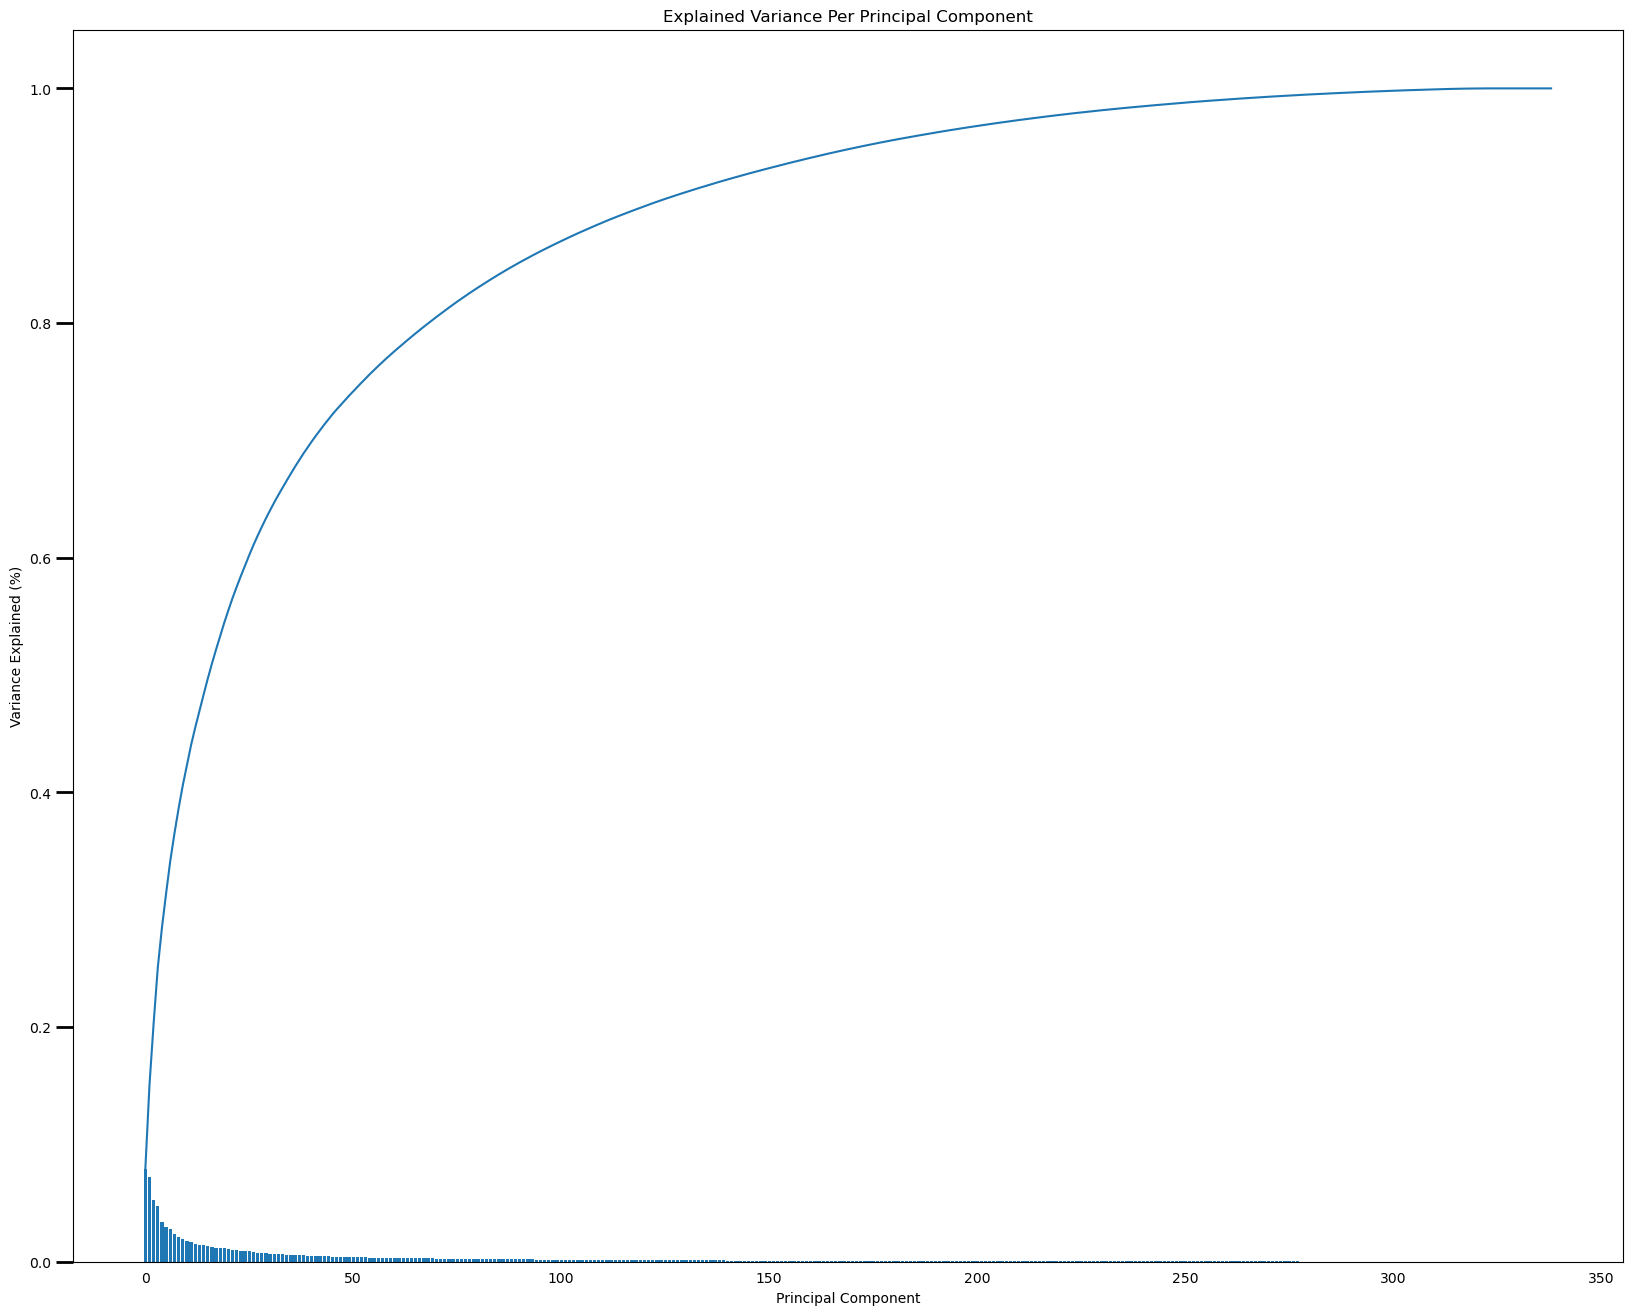

In [58]:
# Investigating the variance accounted for by each principal component.
def scree_plot(pca: PCA) -> None:
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 16))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
scree_plot(full_pl['reducer'].pca)

In [59]:
# Re-apply PCA to the data while selecting for number of components to retain.
full_pl['reducer'].pca.n_components = 100
X_pca = full_pl['reducer'].pca.fit_transform(df_norm)

In [60]:
# Ensuring that the amount of reduced features corresponds to the desired amount
assert len(full_pl['reducer'].pca.explained_variance_ratio_) == 100, "Number of features mismatch: {} != {}".format(
       len(full_pl['reducer'].pca.explained_variance_ratio_), 100)
print("Number of features match")

Number of features match


### Step 1.3: Interpret Principal Components

In [61]:
# Turning the components_ ndarray(n_components, n_features) into a DataFrame for visualization purposes
df_components = pd.DataFrame(full_pl['reducer'].pca.components_, columns = df_norm.columns)

In [62]:
def print_first_n_feat_per_component(df: pd.DataFrame, component: int, n_disp_feat: int = 6) -> list:
    '''
    Prints the first n_disp_feat positive and negative weights sorted in a decreasing fashion, along eith their related features of a given component
    
    INPUT: df          - DataFrame whose rows represent the components and columns the features
           component   - Integer with the position of the component in df
           n_disp_feat - Number of features to display (default 6)
            
    OUTPUT:
            list wit the names of the features related to the weights 
    '''

    sorted_weights = df.iloc[component].sort_values(ascending = False)
    selected_weights = pd.concat([sorted_weights[:n_disp_feat], sorted_weights[-n_disp_feat:]], axis=0)
    
    selected_weights.plot(kind='bar', rot=45, figsize=(15, 8), 
                          title='Component ' + str(component+1), 
                          xlabel='Features', ylabel='weigths',
                          color=plt.cm.Paired(np.arange(selected_weights.shape[0])))

    return list(selected_weights.index)

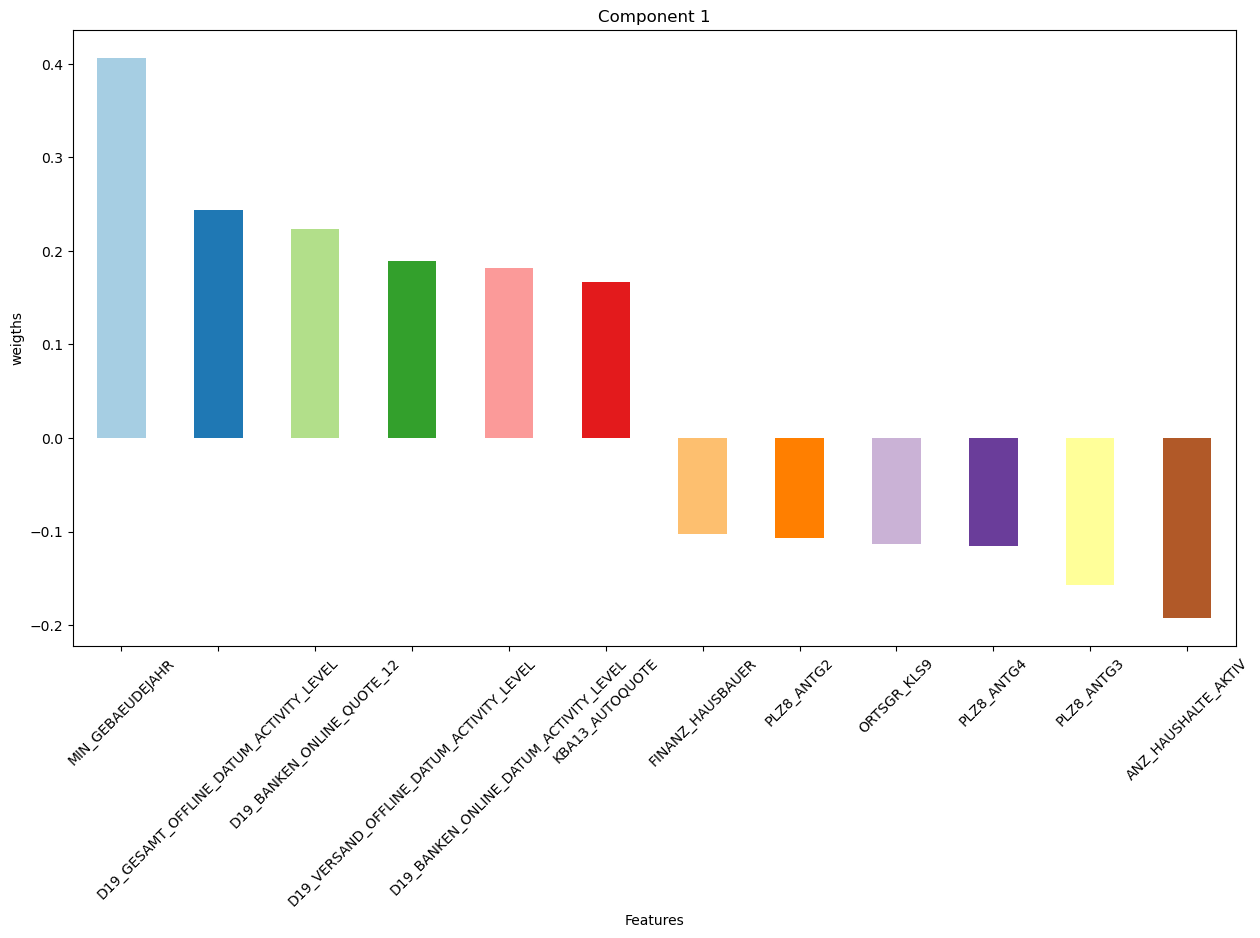

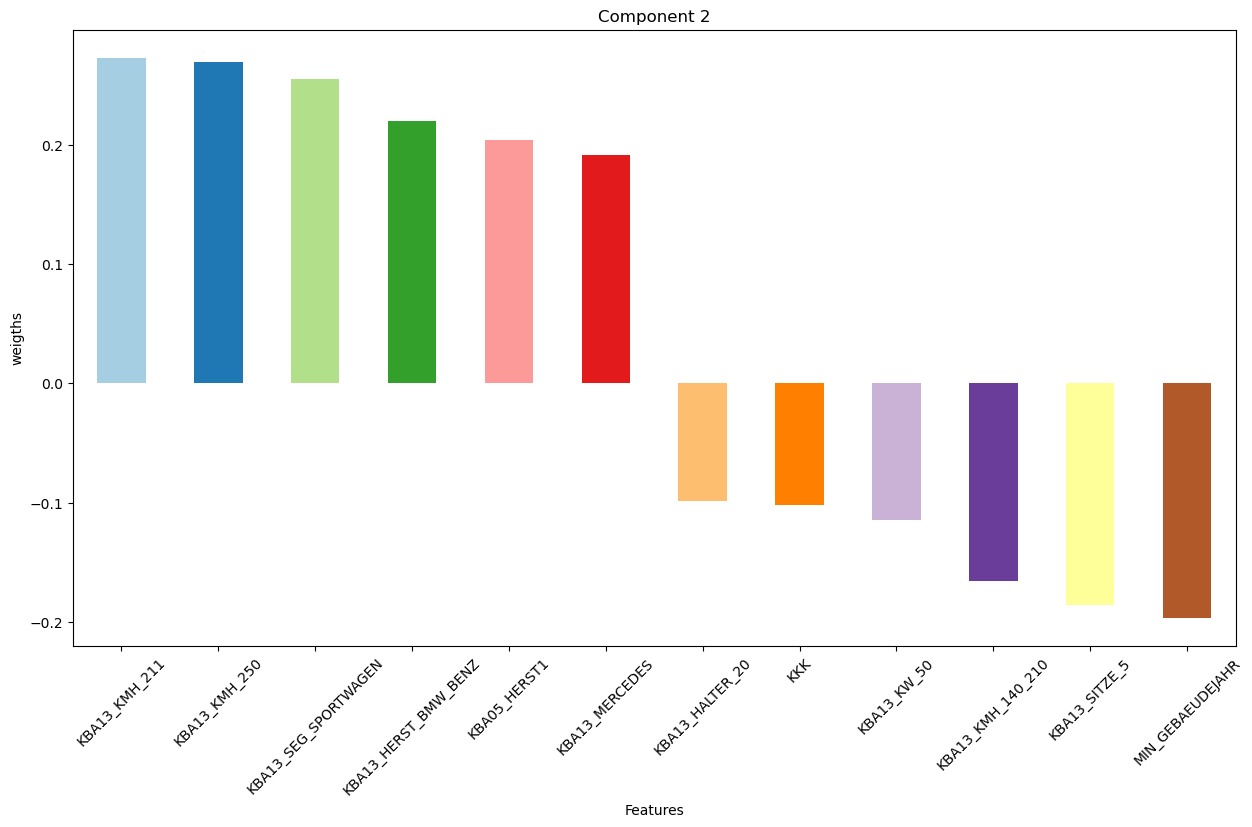

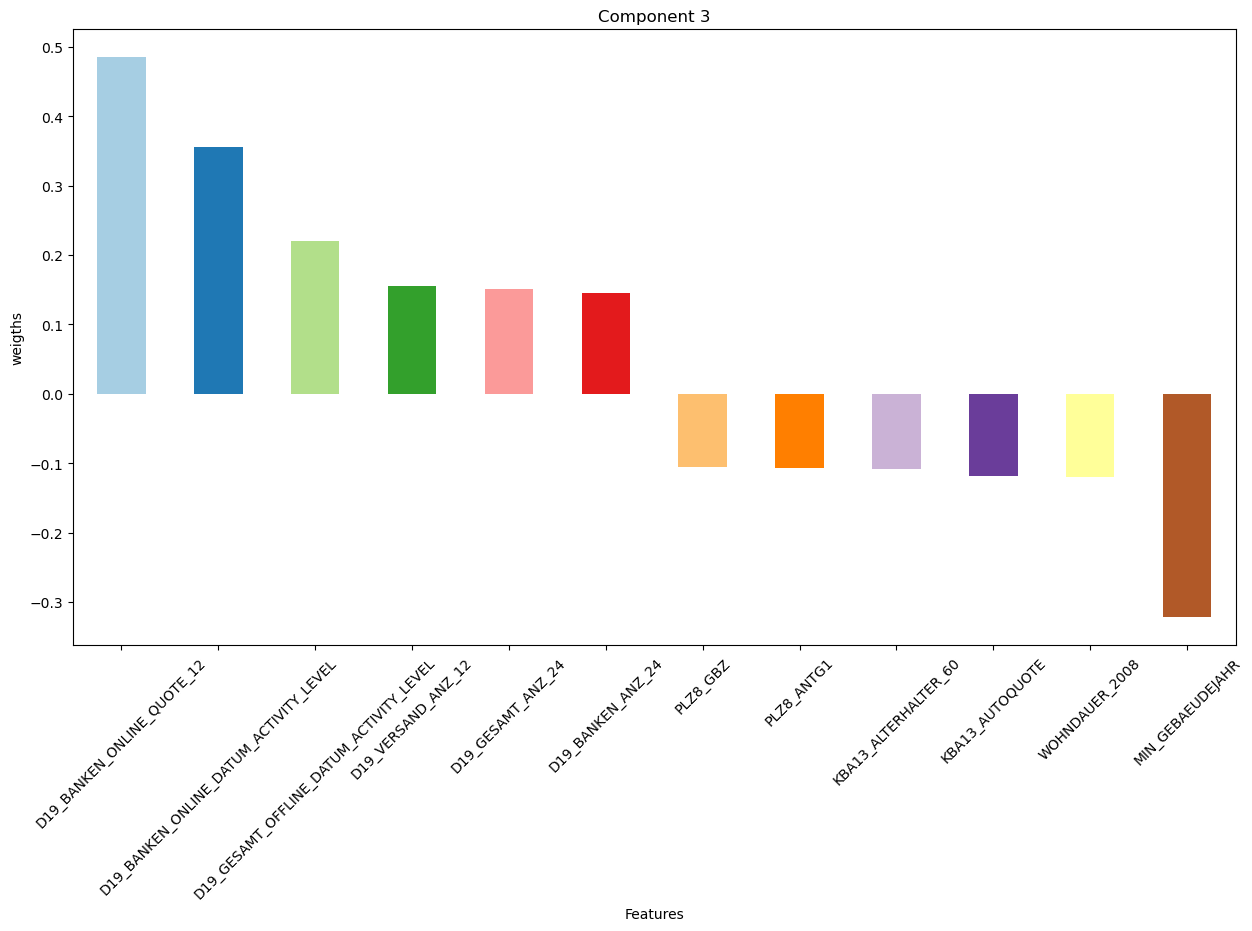

In [63]:
# Map weights for the first three principal components to corresponding feature names
# and then print the linked values, sorted by weight.
for component in range(0, 3):
    plt.figure(component+1)
    features = print_first_n_feat_per_component(df=df_components, component=component)

## Step 2: Clustering

### Step 2.1: Apply Clustering to General Population

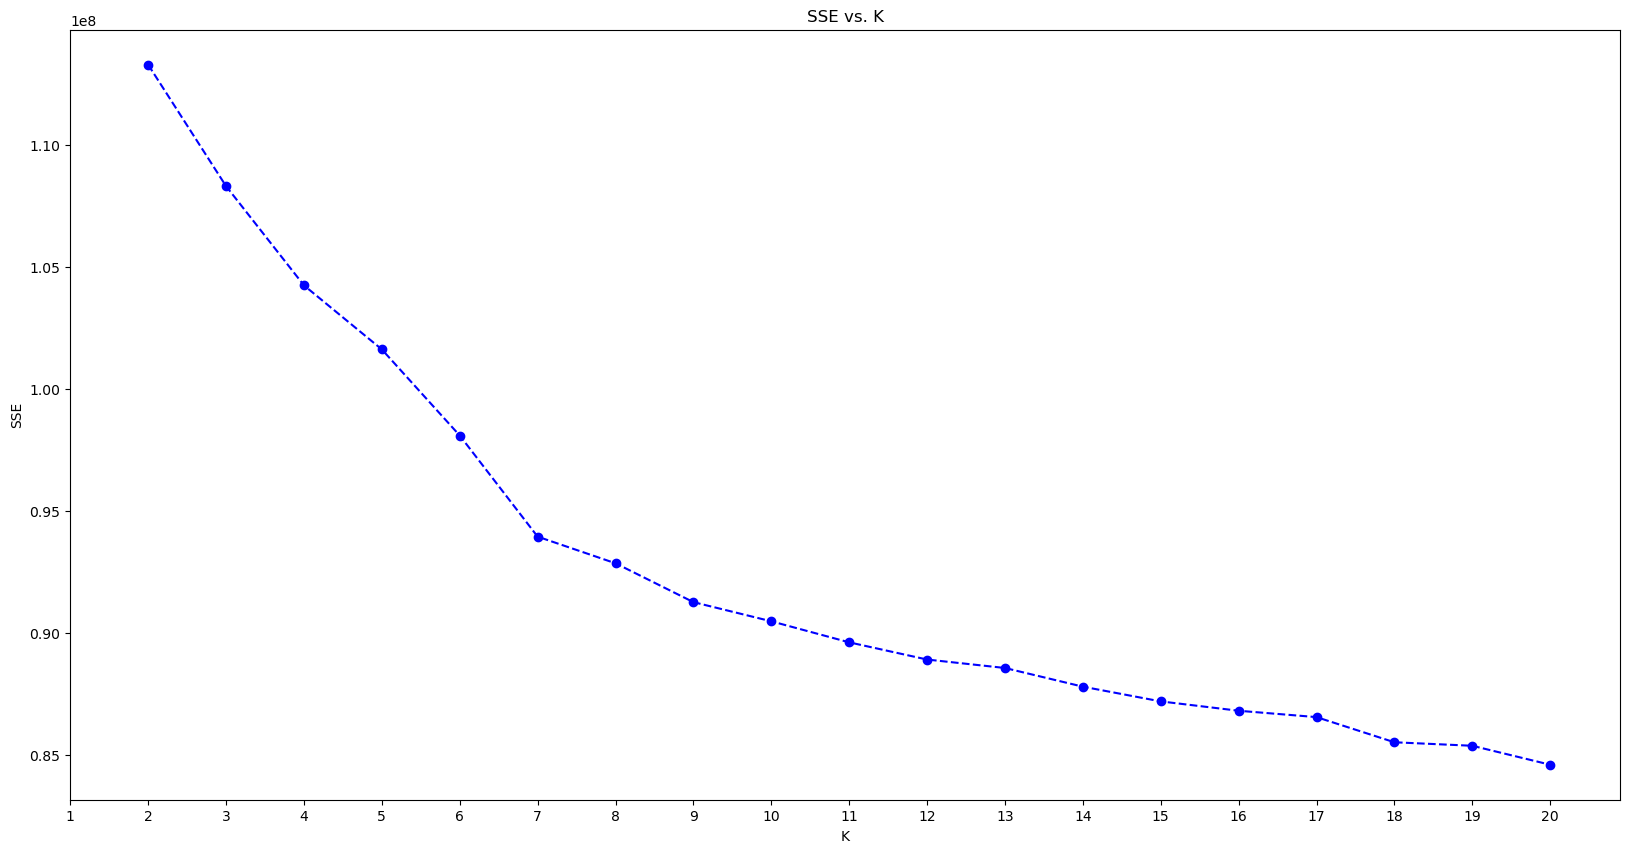

In [64]:
def investigate_best_k_value(data: np.array, max_k: int = 20):
    '''
    This method computes the SSE metric within a given range of k-values to fit the MiniKmeans object and plots them in order 
    to determine the best k-value (where an elbow can be seen in the plotted trace)
    INPUT:
        data (numpy array) - the dataset you want to fit minikmeans to comming from the PCA output object 
    
    OUTPUT: None
    '''

    # Create a faster version of k-means clustering
    kmeans = MiniBatchKMeans(random_state=42)

    scores = []
    n_clusters_tests = range(2, max_k + 1) 
    for n_clusters in n_clusters_tests:
    
        # Updating the number of clusters and re-fitting the kmeans object
        kmeans.n_clusters = n_clusters
        model = kmeans.fit(X_pca)
    
        # Computing the average within-cluster distances.
        score = np.abs(model.score(X_pca))
        scores.append(score)
    
    # Investigating the change in within-cluster distance across number of clusters.    
    plt.figure(figsize=(20,10))
    plt.plot(n_clusters_tests, scores, linestyle='--', marker='o', color='b');
    plt.xticks(range(1, max_k + 1))
    plt.xlabel('K');
    plt.ylabel('SSE');
    plt.title('SSE vs. K');
    
investigate_best_k_value(data=X_pca)

In [65]:
# Fitting the k-means object of the pipeline with the selected number of clusters and obtaining cluster predictions for the 
# general population demographics data.
opt_k = 10
full_pl['cluster'].kmeans.n_clusters = opt_k
full_pl['cluster'].fit(X_pca)
general_labels = full_pl['cluster'].predict(X_pca)

In [66]:
good_clustered = np.where(np.logical_and(general_labels >= 0, general_labels < opt_k))
assert len(good_clustered[0]) == len(general_labels), "Not all clients are correctly clustered"
print('All customers are correctly clustered')

All customers are correctly clustered


### Step 2.2: Apply All Steps to the Customer Data

In [67]:
# Load the processed data of the customers from a pickle file
df_customers_cleaned = load_data_from_pickle_file(filename='processed_customers_data.pk', file_path=PROCESSED_DATA_PATH)

Loaded pickle file ./data/processed_customers_data.pk


In [68]:
# Applying Robust Scaler and PCA transformations as well as predicting the customers clusters using k-means in one go 
customers_labels = full_pl.predict(df_customers_cleaned)

In [69]:
# Checking that the values of all columns are within 0 and 1
df_norm = full_pl['normalizer'].df_normalized
for col in df_norm.columns:
    assert df_norm[col].between(0, 1, inclusive='both').any(), "Some values are not within 0, 1 range in column {}".format(col)
print("All values are within the 0, 1 range")

# Ensuring that the amount of reduced features corresponds to the desired amount
assert len(full_pl['reducer'].pca.explained_variance_ratio_) == 100, "Number of features mismatch: {} != {}".format(
       len(full_pl['reducer'].pca.explained_variance_ratio_), 100)
print("Number of features match")

# Checking that the customer labels are within the desired range
good_clustered = np.where(np.logical_and(customers_labels >= 0, customers_labels < opt_k))
assert len(good_clustered[0]) == len(customers_labels), "Not all clients are correctly clustered"
print('All customers are correctly clustered')

All values are within the 0, 1 range
Number of features match
All customers are correctly clustered


### Step 3.3: Compare Customer Data to Demographics Data

In [70]:
def calc_proportions(labels: list) -> list:
    '''
    This function computes the ratios of each cluster given the list with the ids of the clusters where each element belongs to
    
    INPUT:
        labels - A list with the ids of the clusters where each element is attacthed to 
    OUTPUT:
        proportions - An ordered list with the ratios of each cluster elements with respect to the total  
    '''
    
    n_elements = len(labels)
    amount_per_cluster = Counter(labels)
    amount_per_cluster_sorted = sorted(amount_per_cluster.items())
    proportions = [100*(qty/n_elements) for cluster, qty in amount_per_cluster_sorted]
    return proportions

<Axes: title={'center': 'Ratio representation among clusters for the general and customers data'}, xlabel='Clusters', ylabel='Proportion in %'>

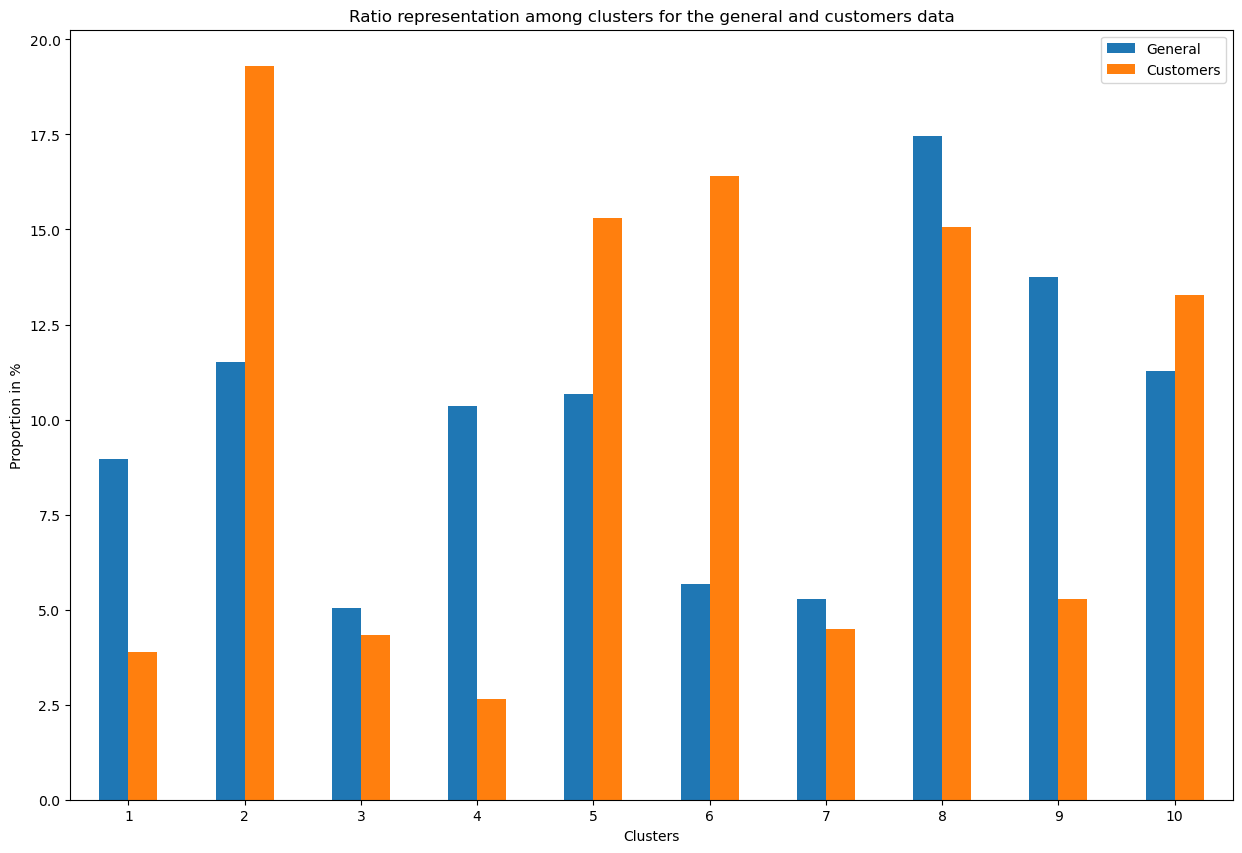

In [71]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Counting the proportions in each dataset
general_proportions = calc_proportions(labels = general_labels)
customer_proportions = calc_proportions(labels = customers_labels)

# Turning into a dataframe
df_proportions = pd.DataFrame({'General': general_proportions, 
                               'Customers': customer_proportions}, 
                              index=range(1, opt_k+1))

# Displaying the bar graph
df_proportions.plot(kind='bar', figsize=(15,10), xlabel='Clusters', ylabel='Proportion in %', 
                    rot = 0,
                    title='Ratio representation among clusters for the general and customers data')

In [72]:
# What kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population?

# Getting the clustered data back to its original space for the overrepresented cluster 6 
df_orig_data_cluster_6 = full_pl.inverse_transform(Xt=None, labels=customers_labels, id_cluster=5)

UnsetMetadataPassedError: [labels, id_cluster] are passed but are not explicitly set as requested or not for Normalizer.inverse_transform

In [67]:
def plot_features_in_principal_component(*, df: pd.DataFrame) -> None:
    '''
    This function plots the histograms of two subsets with the same amount of rows.
    INPUT: df - dataframe with a subset of columns from the original dataframe 
    OUTPUT: None
    '''
    figure, axis = plt.subplots(3, 2, figsize = (50, 50))
    axis = axis.flatten()
    for i, column in enumerate(df):
        sns.countplot(x = df[column], ax=axis[i])
        axis[i].set_ylabel('Number of rows')
    
    figure.show()

In [ ]:
# Let's now analyze the first 3 principal components together with the plot distributions of 
# the features associated with the weights
for component in range(0, 3):
    plt.figure(component+1)
    features = print_first_n_feat_per_component(df=df_components, component=component)
    plot_features_in_principal_component(df=df_orig_data_clustered[features[:3] + features[9:]])

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the customer data compared to the general population?

# Getting the clustered data back to its original space for the most underrepresented cluster 9
df_orig_data_cluster_9 = full_pl.inverse_transform(Xt=None, labels=customers_labels, id_cluster=8)

In [ ]:
# Let's now analyze the first 3 principal components together with the plot distributions of the features associated with 
# the weights
for component in range(0, 3):
    plt.figure(component+1)
    features = print_first_n_feat_per_component(df=df_components, component=component)
    plot_features_in_principal_component(df=df_orig_data_clustered[features[:3] + features[9:]])

In [ ]:
def save_data_to_pickle(data: KMeans, file_name: str, file_path: str = CLUSTER_MODEL_PATH):
    '''
    INPUT:
    data - (Kmeans) the kmeans object to save into a pickle file   
    filename - (string) the file name of the pickle file
    file_path - (string) the path name where the pickle file is held
    
    OUTPUT: None 
    
    '''
    full_path = file_path + filename
    
    try:
        saved_pickle = dump(data, full_path)
    except:
        print('Unable to save pickle file {}'.format(full_path))
    else:
        print('Saved pickle file {}'.format(full_path))

In [ ]:
# Save the fitted cluster model to a pickle file for later use
save_data_to_pickle(data=full_pl['cluster'].kmeans, file_name='kmeans_model.pk')